In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from statsmodels.stats.outliers_influence import variance_inflation_factor #VIF

In [ ]:
### Table : train
conn = pymysql.connect(host='localhost'
                       ,user = 'root'
                       ,password = 'dbdb1021&'
                       ,db='ion'
                       ,charset='utf8'
                       ,cursorclass=pymysql.cursors.DictCursor)
cursor = conn.cursor()

for val in ['train', 'ttf', 'fault']:
    # 4단계 : sql문 작성(데이터 read)
    sql = "SELECT * FROM ion.m02_01_{};".format(val)

    # 5단계 : sql문 실행(데이터 read)
    cursor.execute(sql)

    # 6단계 : fetch 메서드(조회결과 콘솔창에서 보기 위함)
    result = cursor.fetchall() # fetchall() : 전부 가져오기

    # 9단계 : df
    globals()['df_{}'.format(val)] = pd.DataFrame(result)

# 8단계 : commit 및 연결 해제
conn.commit() # 커밋은 반복할 필요 없음
conn.close()

In [ ]:
# train.csv
std = df_train['IONGAUGEPRESSURE'].std()
df_train_c = df_train[(df_train['IONGAUGEPRESSURE']<=std*3) & (df_train['IONGAUGEPRESSURE']>=std*(-3))]
print(df_train_c.shape)

std = df_train['ETCHSUPPRESSORCURRENT'].std()
df_train_c = df_train_c[(df_train_c['ETCHSUPPRESSORCURRENT']<=std*3) & (df_train_c['ETCHSUPPRESSORCURRENT']>=std*(-3))]
print(df_train_c.shape)

std = df_train['FLOWCOOLPRESSURE'].std()
df_train_c = df_train_c[(df_train_c['FLOWCOOLPRESSURE']<=std*3) & (df_train_c['FLOWCOOLPRESSURE']>=std*(-3))]
print(df_train_c.shape)

# ttf.csv
df_ttf_dup = df_ttf[df_ttf.duplicated(subset='time')==False]

# print
df_train_c[:5]
df_ttf_dup[:5]

(5109975, 24)
(5109939, 24)
(5092355, 24)


,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3283834,01M02,1,9253,10511673,67,1,-0.079428,-0.958814,-0.959509,...,-1.751661,-2.783162,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
1,3283838,01M02,1,9253,10511673,67,1,-0.079419,-0.958928,-0.959651,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
2,3283842,01M02,1,9253,10511673,67,1,-0.079409,-0.959156,-0.960006,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
3,3283846,01M02,1,9253,10511673,67,1,-0.079420,-0.958928,-0.959297,...,-1.747158,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
4,3283850,01M02,1,9253,10511673,67,1,-0.079430,-0.959269,-0.959438,...,-1.747158,-2.784389,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785


In [3]:
df_train_c = pd.read_csv('01_M02_DC_train_pre.csv').iloc[:, 1:]
df_ttf_dup = pd.read_csv('01_M02_DC_train_ttf_dup.csv')
df = pd.merge(df_train_c, df_ttf_dup.iloc[:,:2], how='left', on='time')
df = df.dropna()
df = df.reset_index(drop=True)
df[:5]

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,TTF_FlowCool Pressure Dropped Below Limit
0,3283834,01M02,1,9253,10511673,67,1,-0.079428,-0.958814,-0.959509,...,-2.783162,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785,623234.0
1,3283838,01M02,1,9253,10511673,67,1,-0.079419,-0.958928,-0.959651,...,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785,623230.0
2,3283842,01M02,1,9253,10511673,67,1,-0.079409,-0.959156,-0.960006,...,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785,623226.0
3,3283846,01M02,1,9253,10511673,67,1,-0.079420,-0.958928,-0.959297,...,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785,623222.0
4,3283850,01M02,1,9253,10511673,67,1,-0.079430,-0.959269,-0.959438,...,-2.784389,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785,623218.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4621786 entries, 0 to 4621792
Data columns (total 25 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   time                                       int64  
 1   Tool                                       object 
 2   stage                                      int64  
 3   Lot                                        int64  
 4   runnum                                     int64  
 5   recipe                                     int64  
 6   recipe_step                                int64  
 7   IONGAUGEPRESSURE                           float64
 8   ETCHBEAMVOLTAGE                            float64
 9   ETCHBEAMCURRENT                            float64
 10  ETCHSUPPRESSORVOLTAGE                      float64
 11  ETCHSUPPRESSORCURRENT                      float64
 12  FLOWCOOLFLOWRATE                           float64
 13  FLOWCOOLPRESSURE                          

# 다중공선성

In [4]:
temp = df.iloc[:, 7:-1]
temp = temp[temp.columns.difference(['FIXTURESHUTTERPOSITION'])]
temp[:5]

,ACTUALROTATIONANGLE,ACTUALSTEPDURATION,ETCHAUX2SOURCETIMER,ETCHAUXSOURCETIMER,ETCHBEAMCURRENT,ETCHBEAMVOLTAGE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,ETCHSOURCEUSAGE,ETCHSUPPRESSORCURRENT,ETCHSUPPRESSORVOLTAGE,FIXTURETILTANGLE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,IONGAUGEPRESSURE,ROTATIONSPEED
0,-0.122437,4.037785,3.175941,2.871511,-0.959509,-0.958814,-1.751661,-2.783162,2.39537,-0.939043,-0.946194,2.027848,-2.842907,-2.332807,-0.079428,-0.013207
1,-0.122437,4.037785,3.175941,2.871511,-0.959651,-0.958928,-1.743905,-2.780884,2.39537,-0.939043,-0.946103,2.027848,-2.842907,-2.332807,-0.079419,-0.013207
2,-0.122437,4.037785,3.175941,2.871511,-0.960006,-0.959156,-1.743905,-2.780884,2.39537,-0.939043,-0.946057,2.027848,-2.841850,-2.332807,-0.079409,-0.013207
3,-0.122437,4.037785,3.175941,2.871511,-0.959297,-0.958928,-1.747158,-2.780884,2.39537,-0.939043,-0.946148,2.027848,-2.841850,-2.332807,-0.079420,-0.013207
4,-0.122437,4.037785,3.175941,2.871511,-0.959438,-0.959269,-1.747158,-2.784389,2.39537,-0.939043,-0.946057,2.027848,-2.841850,-2.332807,-0.079430,-0.013207


<Axes: >

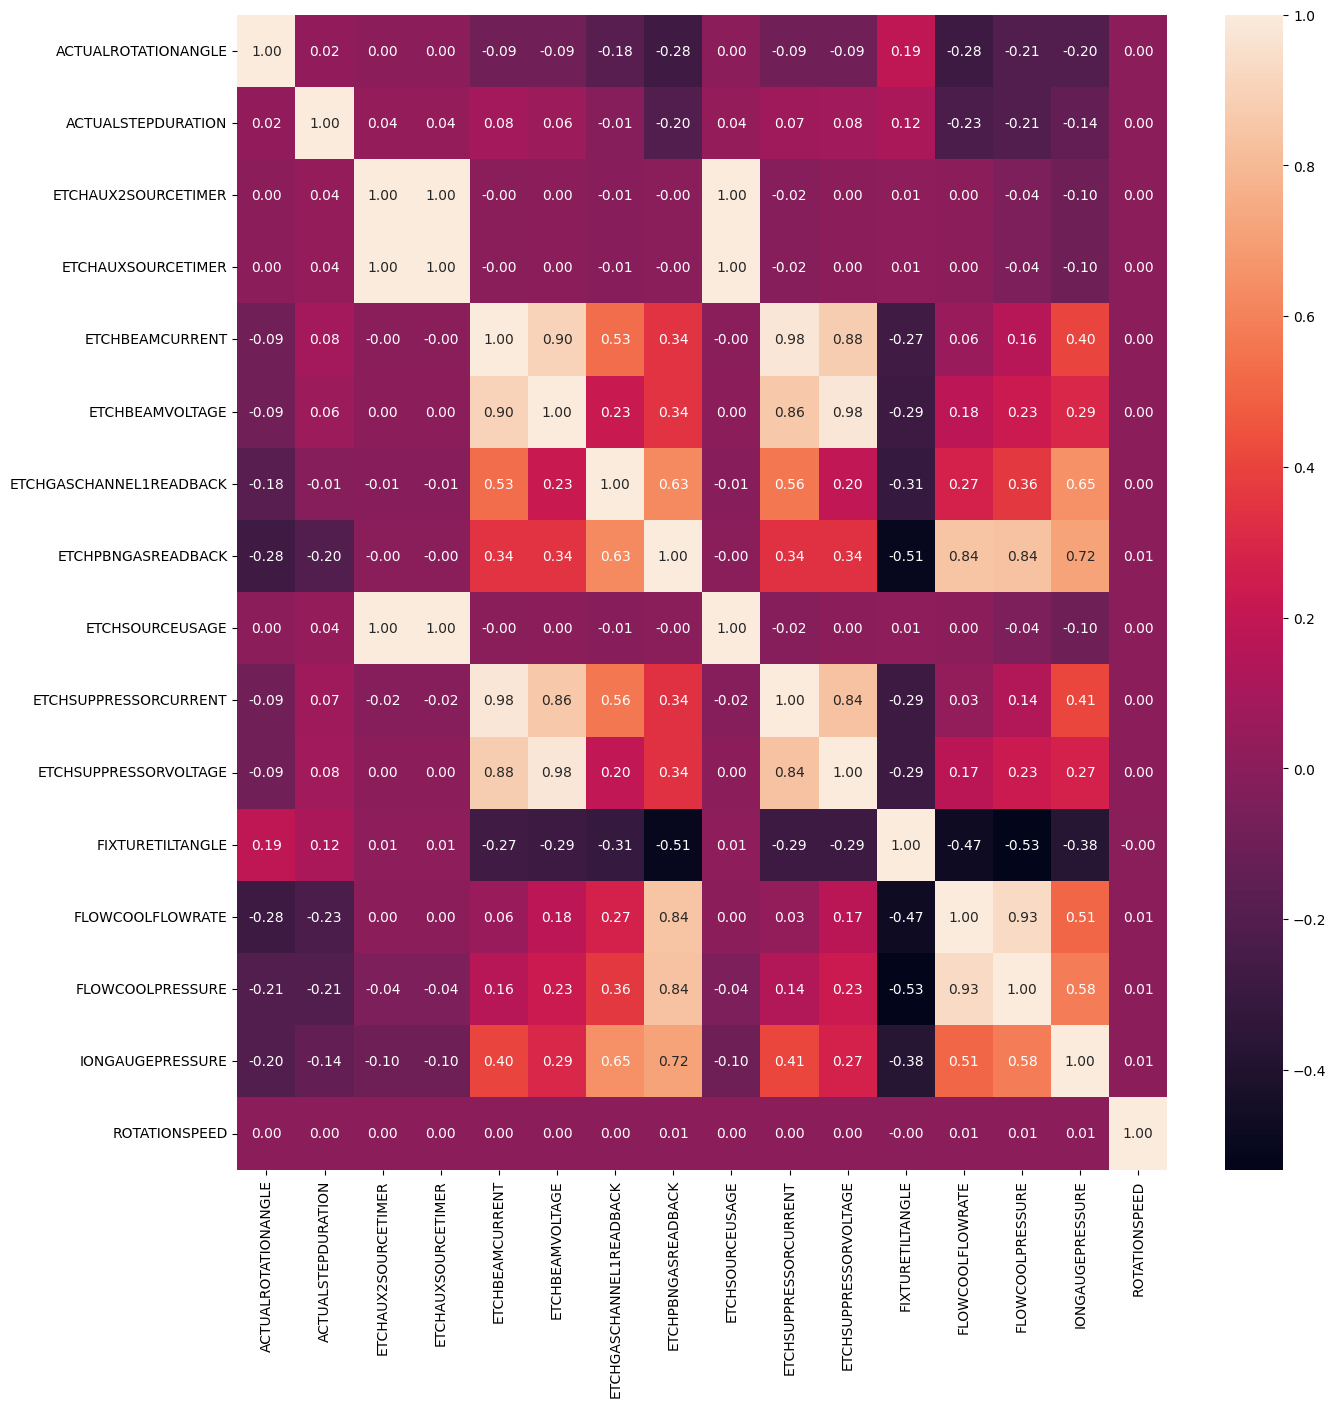

In [17]:
plt.figure(figsize=(15,15))
sns.heatmap(temp.corr(), annot=True, fmt='.2f')

In [5]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(temp.values, i) for i in range(temp.shape[1])]
vif["features"] = temp.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.018389,ROTATIONSPEED
1,1.156211,ACTUALSTEPDURATION
2,1.173053,ACTUALROTATIONANGLE
3,1.545297,FIXTURETILTANGLE
4,2.659163,IONGAUGEPRESSURE
5,10.355943,FLOWCOOLPRESSURE
6,12.470813,ETCHGASCHANNEL1READBACK
7,13.438016,ETCHPBNGASREADBACK
8,14.341747,FLOWCOOLFLOWRATE
9,25.241501,ETCHSUPPRESSORVOLTAGE


In [7]:
scale = MinMaxScaler()

for i in [11, 32, 70, 10000]:
    temp2 = temp[vif[vif['VIF Factor']<i]['features'].values]
    
    scale.fit(temp2)
    temp_scaled = scale.transform(temp2)

    train_input, test_input, train_target, test_target = train_test_split(temp_scaled, df.iloc[:, -1], test_size=0.2, random_state=42)
    
    lr = LinearRegression()

    # 훈련
    lr.fit(train_input, train_target)

    # # 과적합 여부 확인
    print(i, '-'*35)
    print("훈련 정확도 : ", lr.score(train_input, train_target))
    print("테스트 정확도 : ", lr.score(test_input, test_target))

    # 평균오차 확인
    test_pred = lr.predict(test_input)
    print('절대값에 의한 오차 : ', mean_squared_error(test_pred, test_target))


11 -----------------------------------
훈련 정확도 :  0.0032837831712937415
테스트 정확도 :  0.0033135464184489427
절대값에 의한 오차 :  5159478219601.608
32 -----------------------------------
훈련 정확도 :  0.01719625240826106
테스트 정확도 :  0.017239810919361
절대값에 의한 오차 :  5087387083904.25
70 -----------------------------------
훈련 정확도 :  0.02847339693897355
테스트 정확도 :  0.02847071189040018
절대값에 의한 오차 :  5029248851225.001
10000 -----------------------------------
훈련 정확도 :  0.12562440689959264
테스트 정확도 :  0.12511830341663943
절대값에 의한 오차 :  4528939910870.989


In [29]:
for i in [11, 32, 70, 10000]:
    model_boston1 = sm.OLS(df.iloc[:,-1], temp[vif[vif['VIF Factor']<i]['features'].values])
    result_boston1 = model_boston1.fit()
    print(result_boston1.summary())

                                            OLS Regression Results                                            
Dep. Variable:     TTF_FlowCool Pressure Dropped Below Limit   R-squared (uncentered):                   0.023
Model:                                                   OLS   Adj. R-squared (uncentered):              0.023
Method:                                        Least Squares   F-statistic:                          1.798e+04
Date:                                       Thu, 05 Oct 2023   Prob (F-statistic):                        0.00
Time:                                               15:04:06   Log-Likelihood:                     -7.5959e+07
No. Observations:                                    4621786   AIC:                                  1.519e+08
Df Residuals:                                        4621780   BIC:                                  1.519e+08
Df Model:                                                  6                                                  
C

- 15개 다 넣었을 때가 0.598로 가장 예측력이 좋다
---
# 모델

In [16]:
df[df['TTF_FlowCool Pressure Dropped Below Limit']==0]

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,TTF_FlowCool Pressure Dropped Below Limit
131031,3907068,01M02,1,9361,10548007,67,43,-0.022398,1.188755,0.789706,...,0.358499,0.022131,-0.013207,-0.122455,1.0,2.787074,3.309810,3.631607,0.803526,0.0
144063,3962388,01M02,1,9194,10551521,67,49,0.011108,1.187162,0.786655,...,0.352016,0.022131,-0.013207,-0.122455,1.0,2.802185,3.326749,3.649218,0.803526,0.0
146075,3971424,01M02,1,9194,10551521,67,46,-0.050470,-0.840118,-0.959509,...,0.326081,-0.646442,-0.013207,-0.122455,0.0,2.806268,3.331319,3.653969,0.803526,0.0
146556,3973348,01M02,1,9194,10551521,67,52,-0.079494,-0.959099,-0.959580,...,-2.787718,-0.646442,-0.013207,-0.122464,0.0,2.806501,3.331583,3.654243,0.803526,0.0
816395,8072052,01M02,1,9289,10810825,67,25,0.013171,0.711466,1.375094,...,0.357450,0.022131,-0.013207,-0.122455,1.0,0.523792,0.777750,0.999215,-0.304990,0.0
822297,8123030,01M02,1,9295,10815254,67,19,0.013694,0.950167,0.990015,...,0.362004,-0.646442,-0.013207,-0.122455,1.0,0.526125,0.780385,1.001955,-0.683190,0.0
822786,8124986,01M02,1,9295,10815254,67,27,-0.079422,-0.958246,-0.958942,...,-2.787718,-0.646442,-0.013207,-0.122464,0.0,0.526417,0.780716,1.002298,-0.657107,0.0
822898,8125434,01M02,1,9295,10815254,67,37,-0.075054,-0.959042,-0.959013,...,-2.787718,2.027848,-0.013207,-0.122455,0.0,0.526652,0.780983,1.002576,-0.304990,0.0
823320,8127122,01M02,1,9295,10815254,67,43,0.014220,0.710330,1.244443,...,0.357450,-0.646442,-0.013207,-0.122446,0.0,0.526848,0.781209,1.002811,-0.304990,0.0
2203095,18108796,01M02,88,3605,11472802,68,3,0.004714,1.546785,0.771974,...,0.360776,-0.200727,-0.013207,-0.122446,1.0,0.040941,0.243947,0.444260,-0.604941,0.0


In [146]:
temp = df.iloc[:, 7:]
temp = temp[temp.columns.difference(['FIXTURESHUTTERPOSITION'])]
temp = temp[vif[vif['VIF Factor']<i]['features'].values]

train_input, test_input, train_target, test_target = train_test_split(temp_scaled[:131030, :-1], temp_scaled[:131030, -1], test_size=0.2, random_state=42)

In [152]:
temp = df.iloc[:, 7:]
temp = temp[temp.columns.difference(['FIXTURESHUTTERPOSITION'])]

scale = MinMaxScaler()
scale.fit(temp)
temp_scaled = scale.transform(temp)

train_input, test_input, train_target, test_target = train_test_split(temp_scaled[:, :-1], temp_scaled[:, -1], test_size=0.2, random_state=42)

In [153]:
temp = df.iloc[:, 7:]
temp = temp[temp.columns.difference(['FIXTURESHUTTERPOSITION'])]
temp = temp[vif[vif['VIF Factor']<i]['features'].values]

train_input, test_input, train_target, test_target = train_test_split(temp_scaled[:131030, :-1], temp_scaled[:131030, -1], test_size=0.2, random_state=42)

lr = LinearRegression()

# 훈련
lr.fit(train_input, train_target)

# # 과적합 여부 확인
print("훈련 정확도 : ", lr.score(train_input, train_target))
print("테스트 정확도 : ", lr.score(test_input, test_target))

# 평균오차 확인
test_pred = lr.predict(test_input)
print('절대값에 의한 오차 : ', mean_squared_error(test_pred, test_target))

훈련 정확도 :  0.1256244068995922
테스트 정확도 :  0.12511830341663976
절대값에 의한 오차 :  0.04600528683796751


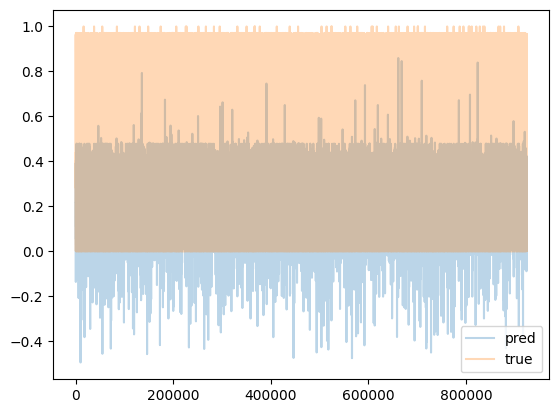

In [155]:
plt.plot(range(len(test_pred)), test_pred, alpha=0.3)
plt.plot(range(len(test_pred)), test_target, alpha=0.3)
plt.legend(['pred', 'true'])
plt.show()

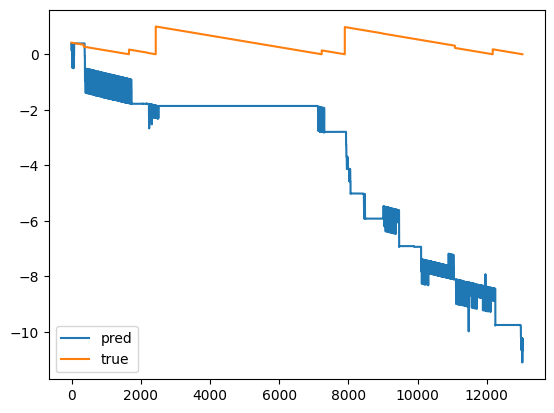

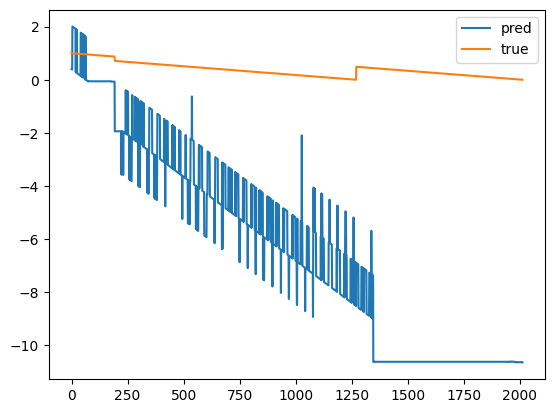

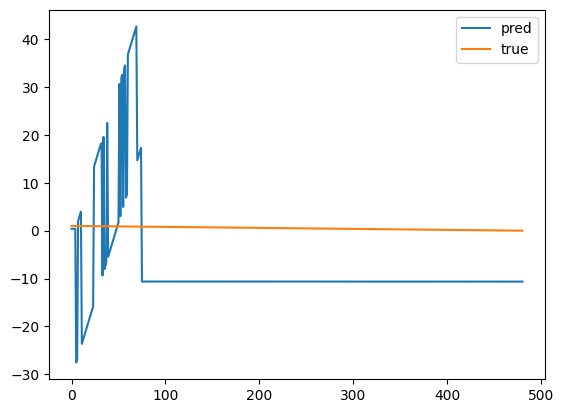

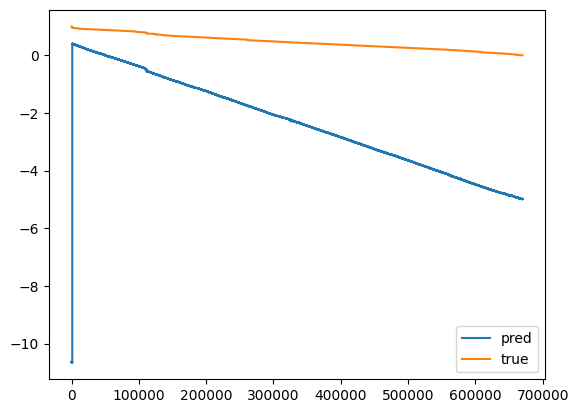

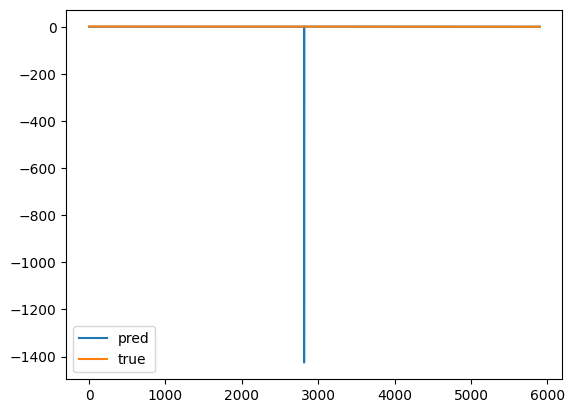

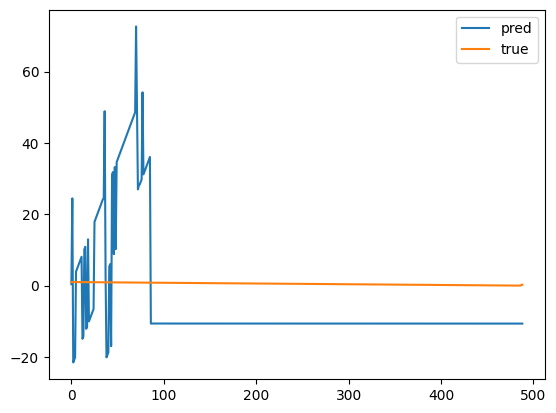

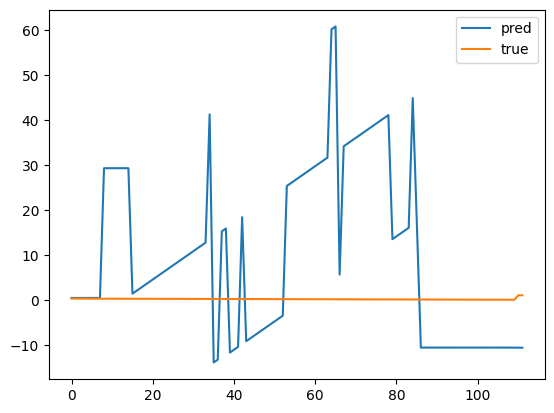

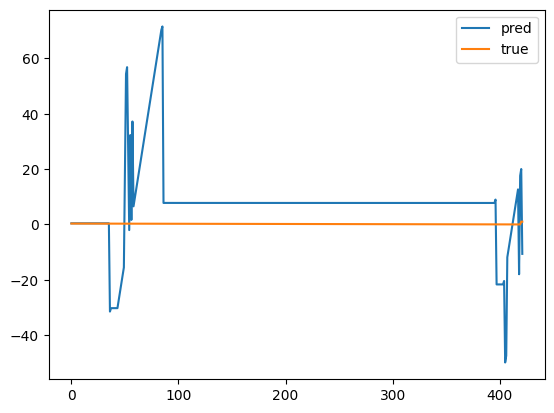

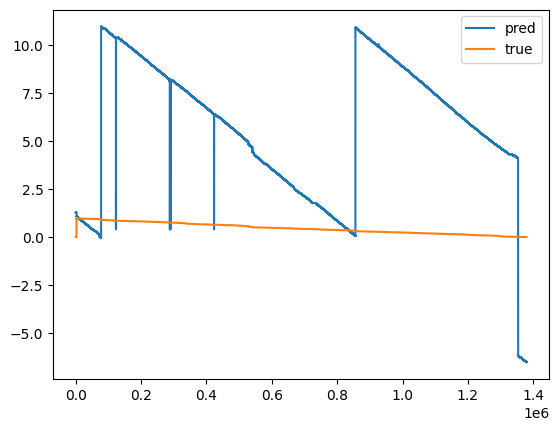

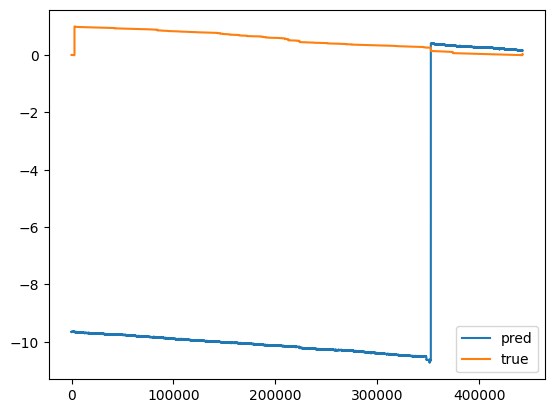

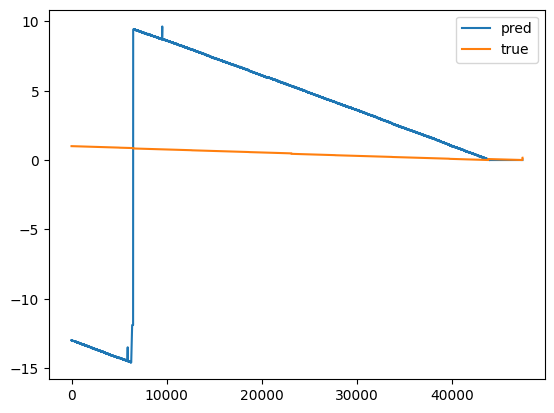

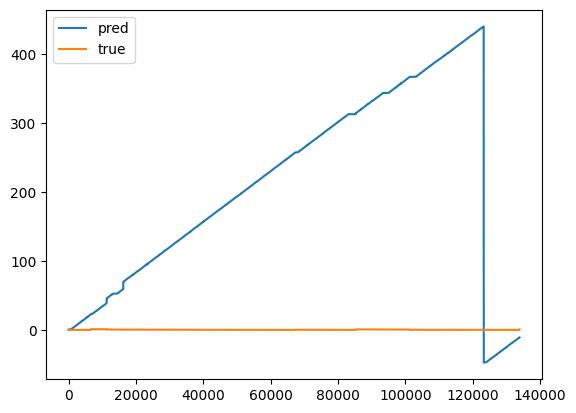

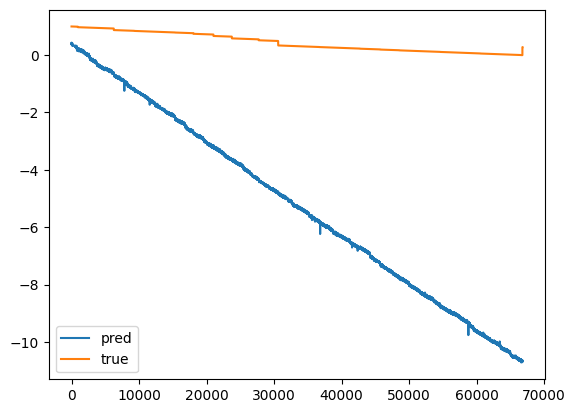

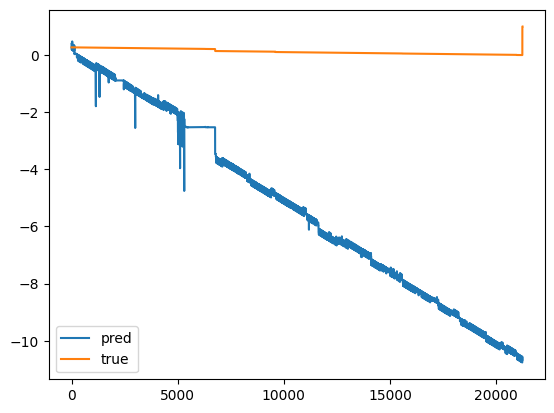

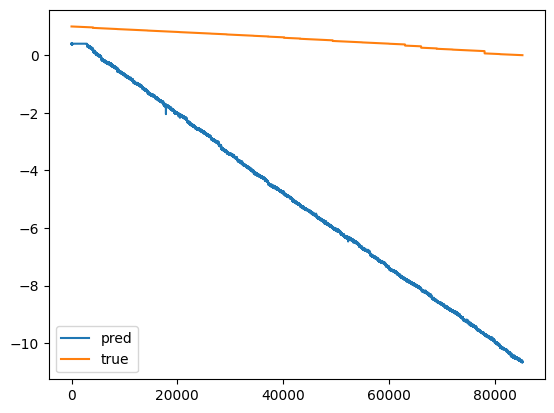

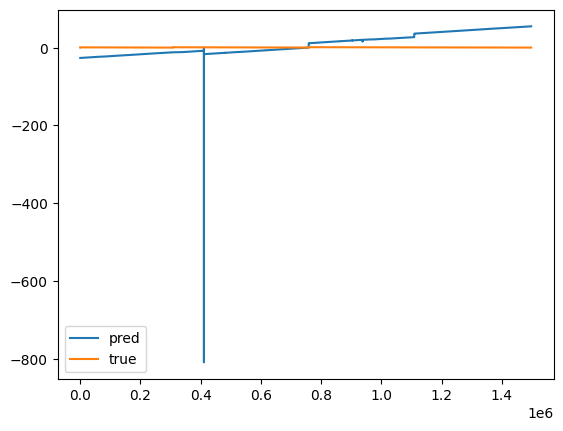

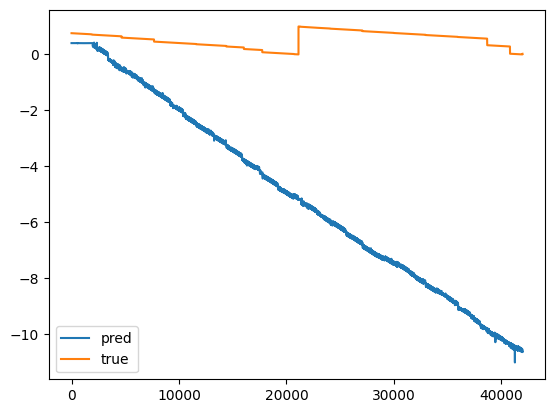

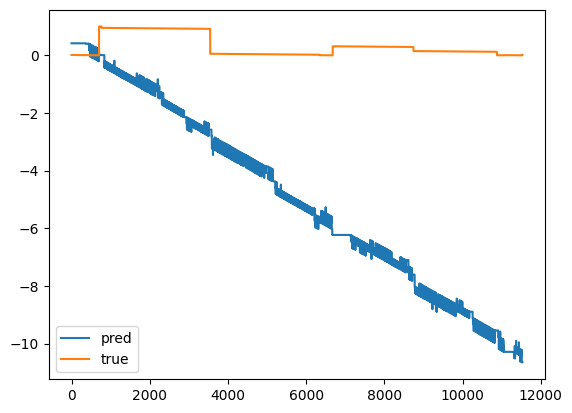

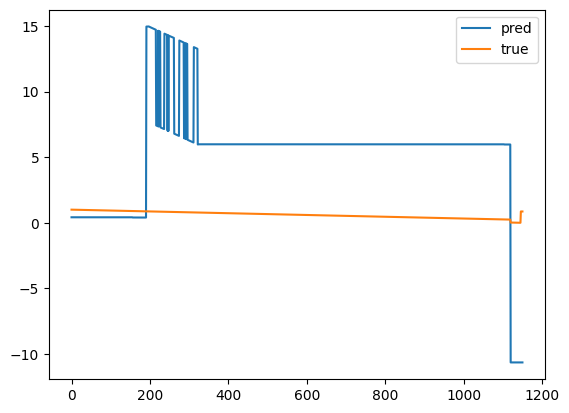

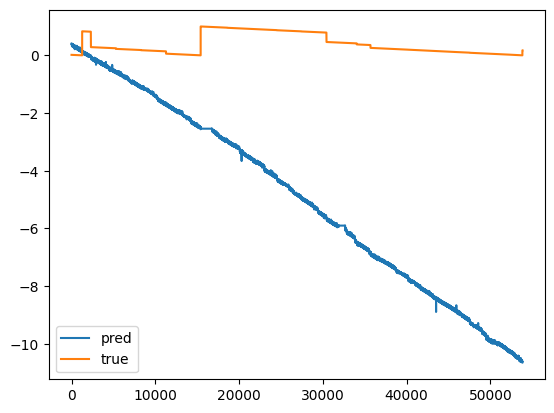

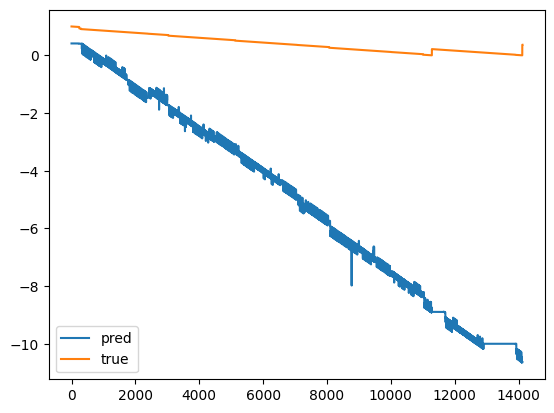

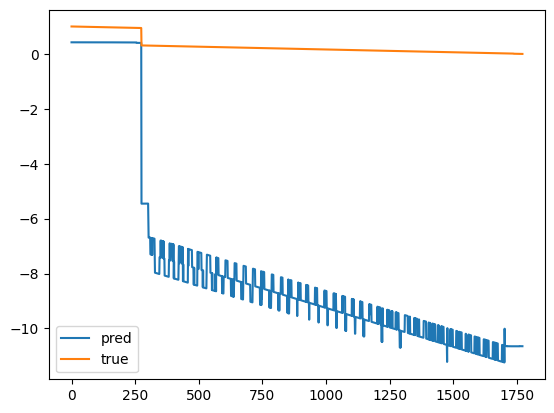

In [151]:
lis = df[df['TTF_FlowCool Pressure Dropped Below Limit']==0].index
lis = lis-1

for i in range(len(lis)-1):
    temp = df.iloc[lis[i]:lis[i+1], 7:]
    temp = temp[temp.columns.difference(['FIXTURESHUTTERPOSITION'])]

    scale = MinMaxScaler()
    scale.fit(temp)
    temp_scaled = scale.transform(temp)

    plt.plot(range(len(temp_scaled)), lr.predict(temp_scaled[:, :-1]))
    plt.plot(range(len(temp_scaled)), temp_scaled[:, -1])
    plt.legend(['pred', 'true'])
    plt.show()